Material heavily borrowed from David I. Ketcheson's [HyperPython](https://github.com/ketch/HyperPython) under a similar license as the one below.  Mistakes introduced are the responsiblility of Kyle Mandli so complain to him.

<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display

def ianimate(xc,q,bounds=(0,1,-0.1,1.1)):
    fig = plt.figure(figsize=(8,4))
    axes = fig.add_subplot(1, 1, 1)
    im, = axes.plot([], [], 'ob--', linewidth=1)
    axes.set_xlim(bounds[:2])
    axes.set_ylim(bounds[2:])

    def fplot(i):
        im.set_data(xc, q[i])
        return im

    return animation.FuncAnimation(fig, fplot, frames=len(q))

$$
    \newcommand{imh}{ {i-1/2} }
    \newcommand{iph}{ {i+1/2} }
    \newcommand{Dx}{\Delta x}
    \newcommand{Dy}{\Delta y}
    \newcommand{DQ}{\Delta Q}
    \newcommand{Dt}{\Delta t}
    \DeclareMathOperator{\sgn}{sgn}
$$

# Finite Volume Methods

## Hyperbolic Conservation Laws

Before we specifically discuss finite volume methods we will explore the class of PDEs that are *hyperbolic conservation laws*.  These equations generally describe the movement of some physical quantity that should be conserved.  Examples of these quantities include mass, momentum, or energy.

### Conservation of Mass

Imagine a fluid flowing in a narrow tube.  We'll use $q$ to indicate the density of the fluid and $u$ to indicate its velocity.  Both of these are functions of space and time: $q = q(x,t)$; $u=u(x,t)$.  The total mass in the section of tube $[x_1,x_2]$ is

\begin{equation}
\int_{x_1}^{x_2} q(x,t) dx.
\end{equation}

This total mass can change in time due to fluid flowing in or out of this section of the tube.  We call the rate of flow the *flux*, and represent it with the function $f(q)$.  Thus the net rate of flow of mass into (or out of) the interval $[x_1,x_2]$ at time $t$ is

$$f(q(x_1,t)) - f(q(x_2,t)).$$

We just said that this rate of flow must equal the time rate of change of total mass; i.e.

$$\frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = f(q(x_1,t)) - f(q(x_2,t)).$$

Now since $\int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx = f(q(x_2,t)) - f(q(x_1,t))$, we can rewrite this as

$$\frac{d}{dt} \int_{x_1}^{x_2} q(x,t) dx = -\int_{x_1}^{x_2} \frac{\partial}{\partial x} f(q) dx.$$

Under certain smoothness assumptions on $q$, we can move the time derivative inside the integral.  We'll also put everything on the left side, to obtain

$$\int_{x_1}^{x_2} \left(\frac{\partial}{\partial t}q(x,t) + \frac{\partial}{\partial x} f(q)\right) dx = 0.$$

Since this integral is zero for *any* choice of $x_1,x_2$, it must be that the integrand (the expression in parentheses) is actually zero *everywhere*!  Therefore we can write the **differential conservation law**

$$q_t + f_x = 0.$$

Here and throughout the course, we use subscripts to denote partial derivatives.
This equation expresses the fact that the total mass is conserved -- since locally the mass can change only due to a net inflow or outflow.

### Advection 

In order to solve the conservation law above, we need an expression for the flux, $f$.  The rate of flow is just mass times velocity: $f=u q$.  Thus we obtain the **continuity equation**

$$q_t + (uq)_x = 0.$$

In general, we need another equation to determine the velocity $u(x,t)$.  Late we will look at the full equations of fluid dynamics, but for now let's consider the simplest case, in which all of the fluid flows at a single, constant velocity $u(x,t)=a$.  Then the continuity equation becomes the *advection equation*

$$q_t + a q_x = 0.$$

We already saw that the solution to the advection equation is $$q(x,t) = q_0(x-at).$$  Let's plot the solution of the advection equation on the interval $[0,1]$ for the initial condition $$q_0(x) = e^{-2(x-1/2)^2}.$$  

In [ ]:
from matplotlib import animation
from clawpack.visclaw.JSAnimation import IPython_display

# Grid
x = numpy.linspace(0, 1, 1000)
t = numpy.linspace(0,1)       

# Advection speed
a = 1.0                    

# Initial condition
def q_0(x):
    return numpy.exp(-200.*(x-0.2)**2)

fig = plt.figure(figsize=(8, 4))
axes = fig.add_subplot(1, 1, 1)
line, = axes.plot([], [], linewidth=2)
axes.set_xlim((0, 1))
axes.set_ylim((-0.1, 1.1))

def plot_q(t):
    # Replace the line plot with the solution at time t
    line.set_data(x, q_0(x - a * t))
    
# Animate the solution
animation.FuncAnimation(fig, plot_q, frames=t)

As you can see, the initial pulse just moves to the right at speed $a$ as time advances.  This isn't very interesting, but it captures the most important feature of hyperbolic equations: waves travel at finite speed.

### Finite Volume Method for Advection

We can easily solve the advection equation exactly.  But the advection equation is a prototype for more complicated conservation laws that we will only be able to solve approximately by using numerical methods.  In order to better understand these methods, we will discuss them first in the context of the advection equation.

For simplicity, we'll suppose that we wish to solve the advection equation on the interval $[0,1]$.  We introduce a set of equally spaced *grid cells* of width $\Dx$, and write $x_i$ to mean the center of cell $i$.  Thus the first cell is the interval $[0,\Dx]$ and $x_1=\Dx/2$.  We will also write $x_\imh$ or $x_\iph$ to denote the left or right boundary of cell $i$, respectively.

We write $Q_i$ to denote the *average* value of the solution over cell $i$:

$$Q_i = \frac{1}{\Dx} \int_{x_\imh}^{x_\iph} q \ dx.$$

The simplest finite volume method is obtained by supposing that the solution is actually *equal* to $Q_i$ over all of cell $i$.

![](./images/finite_volume.png)

Suppose $a>0$.  Then the flux into cell $i$ from the left is $a Q_{i-1}$ and the flux out of cell $i$ to the right is $a Q_i$.  Then our integral conservation law reads

$$Q_i'(t) = -\frac{a}{\Dx}\left(Q_i - Q_{i-1}\right).$$

Applying a forward difference in time we obtain the *upwind method*

$$Q^{n+1}_i = Q^n_i -\frac{a \Dt}{\Dx}\left(Q_i - Q_{i-1}\right).$$

We have seen this before, tt's the upwind method!

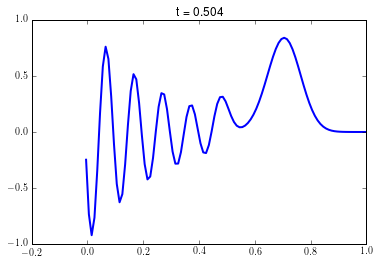

In [4]:
a = 1.0

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-delta_x / 2.0, 1.0 + delta_x / 2.0, delta_x)

t = 0.0
T = 0.5
CFL = 0.8
delta_t = CFL * delta_x / a

# Initial data
Q = numpy.exp(-200.0 * (x - 0.2)**2)
Q_new = numpy.empty(Q.shape)

while t < T:
    
    # Extrapolation at boundaries:
    Q_new[0] = Q[1]
    Q_new[-1] = Q[-2]
    
    # Incoming wave
    # Q_new[0] = numpy.sin(20.0 * numpy.pi * t)
    
    for i in range(1,len(x)):
        Q_new[i] = Q[i] - a * delta_t / delta_x * (Q[i] - Q[i-1])
    
    Q = Q_new.copy()
    t = t + delta_t

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, Q, linewidth = 2)
axes.set_title('t = %s' % str(t))
plt.show()

We can see that we have picked a $\Dt$ based on the CFL condition we derived for finite difference methods.  The same apply here (we are even using the same method).  

Notice how we set up a grid that contains an extra cell at each end, outside of the problem domain $[0,1]$.  These are called *ghost cells* and are often useful in handling the solution at the grid boundaries.

![](./images/ghost-cell.png)

The technique we have used to set the ghost cell values above, by copying the last value inside the grid to the ghost cells, is known as *zero-order extrapolation*.  It is useful for allowing waves to pass out of the domain (so-called *non-reflecting* boundaries).  Note that we don't actually need the ghost cell at the right end for the upwind method, but for other methods we will.

The upwind method is simple, but it is not very accurate.  Notice how the computed solution becomes wider and shorter over time.  This behavior is referred to as *dissipation*.

#### Exercises

Now do the following with the code above:

1. Set $m=1000$ or more and notice that it takes some time to compute the solution.  Rewrite the inner loop (over $i$) as a single line with no loop, using numpy slicing.  For large values of $m$, the code with slicing is much faster.
1. Notice that the last step of the simulation goes past time $T$.  Modify the code so that the last step is adjusted to exactly reach $T$.
2. Change the code so that animation of the solution versus time is plotted.  You will want to accumulate frames of the solution in a list and then use the same kind of code we used above to animate the exact solution.
3. Add some code to plot the exact solution.
4. Change the left boundary condition so that there is a sinusoidal wave coming in from the left:
$$u(0,t) = \sin(20 \pi t).$$
What do you notice about the sinusoid as it moves into the domain?

## Traffic Flow

As an illustrative example we will now consider a particular scalar conservation law, that of a simplified model for traffic flow.  This model is sometimes referred to as the Lighthill-Whitham-Richards (or LWR) traffic model.

From the continuity equation above we know:

$$q_t + (uq)_x = 0.$$

Now we will think of $q$ as the density of cars on a road, traveling with velocity $u$.  Note that we're not keeping track of the individual cars, but just of the average number of cars per unit length of road.  Thus $q=0$ represents an empty stretch of road, and we can choose the units so that $q=1$ represents bumper-to-bumper traffic.

We'll also choose units so that the speed limit is $u_\text{max}=1$, and assume that drivers never go faster than this (yeah, right!)  If we assume that drivers always travel at a single uniform velocity, we obtain once again the advection equation.  But we all know that's not accurate in practice -- cars go faster in light traffic and slower when there is congestion.  The simplest way to incorporate this effect is to make the velocity a linearly decreasing function of the density:

$$u(q) = 1 - q.$$

Notice that $u$ goes to zero as $q$ approaches the maximum density of 1, while $u$ goes to the maximum value of 1 as traffic density goes to zero.  Obviously, both $q$ and $u$ should always stay in the interval $[0,1]$.

![](./images/LWR-Velocity.png)

Combining the two equations above, our conservation law says

$$q_t + (q (1-q))_x = 0.$$

The function $q(1-q)$ is the flux, or the rate of flow of cars.  Notice how the flux is zero when there are no cars and also when the road is completely full.  The maximum flow of traffic actually occurs when the road is half full:

In [ ]:
q = numpy.linspace(0, 1)
f = q * (1.0 - q)
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(q,f,linewidth=2)
axes.set_xlabel('q')
axes.set_ylabel('$f(q)$')
plt.show()

This equation is fundamentally different from the advection equation because the flux is **nonlinear**.  This fact will have dramatic consequences for both the behavior of solutions and our numerical methods.  But we can superficially make this equation look like the advection equation by using the chain rule to write

$$f(q)_x = f'(q) q_x = (1-2q)q_x.$$

Then we have

$$q_t + (1-2q)q_x = 0.$$

This is like the advection equation, but with a velocity $1-2q$ that depends on the density of cars.  The value $f'(q)=1-2q$ is referred to as the *characteristic speed*.  This characteristic speed is not the speed at which cars move (notice that it can even be negative!)  Rather, it is the speed at which *information* is transmitted along the road.

### Shock waves (traffic jams)

Let's use the *Lax-Friedrichs method* to solve the LWR traffic model.

In [ ]:
m = 400
delta_x = 1.0 / m
x = numpy.arange(-delta_x / 2.0, 1.0 + delta_x / 2.0, delta_x)

t = 0.0
T = 0.5
CFL = 0.9
delta_t = CFL * delta_x

Q = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new = numpy.empty(Q.shape)
Q_list = [Q]

while t < T:
    
    Q_new[1:-1] = 0.5 * (Q[:-2] + Q[2:]) - 0.5 * delta_t / delta_x * (Q[2:] *(1.0 - Q[2:]) - Q[:-2] * (1.0 - Q[:-2]))
    
    Q = Q_new.copy()
    Q[0] = Q[-2]
    Q[-1] = Q[1]
    t += delta_t
    Q_list.append(Q)
    
ianimate(x, Q_list)

Starting from an initially smooth distribution of cars, we see that the solution evolves into something discontinuous!  What's going on?

Naturally, the cars in the low-density region behind the peak initially drive faster than the cars in the most congested region, ahead of them.  This leads to a steepening of the rear part of the traffic flow, and eventually there is a traffic jam: cars coming from the back have an open road, until suddenly they reach a highly congested area and must slam on the brakes.  Sound familiar?

#### Exercises

1. Recall our discussion of the CFL condition for advection.  To apply the CFL condition to a nonlinear problem, we use the characteristic velocity (in this case $1-2q$) in place of the velocity $a$.  For this problem, how large can we take the time step without violating the CFL condition? 

1. In the cell below, set things up to find out what happens when cars reach a red light.  Place the red light at $x=1$ and set $q=1$ in the interval $0.8<x<1$ near the light (the cars will be stopped, bumper to bumper there).  In the rest of the domain, set $q=0.2$, corresponding to light traffic.  In the ghost cell at the right boundary, set $q=1$; in the ghost cell at the left set $q=0.2$.  After you have computed the solution, check it against your inuition.  Does it make sense?

### Speed of a shock wave: the Rankine-Hugoniot conditions

In the second exercise above, you should have seen a shock wave (i.e., a discontinuity) that moves to the left as more and more cars pile up behind the red light.  How quickly does this discontinuity move to the left?

We can figure it out by putting an imaginary line at the location of the shock.  Let $q_l$ be the density of cars just to the left of the line, and let $q_r$ be the density of cars just to the right.  Imagine for a moment that the line is stationary.  Then the rate of cars reaching the line from the left is $f(q_l)$ and the rate of cars departing from the line to the right is $f(q_r)$.  If the line really were stationary, we would need to have $f(q_l)-f(q_r)=0$ to avoid cars accumulating at the line.

![](./images/shock_diagram_traffic_a.png)

However, the shock is not stationary, so the line is moving.  Let $s$ be the speed of the shock.  Then as the line moves to the left, some cars that were to the left are now to the right of the line.  The rate of cars removed from the left is $s q_l$ and the rate of cars added on the right is $s q_r$.  So in order to avoid an accumulation of cars at the shock, these two effects need to be balanced:

$$f(q_l) - f(q_r) = s(q_l - q_r).$$

This condition is known as the *Rankine-Hugoniot condition*, and it holds for any shock wave in the solution of any hyperbolic system!

![](./images/shock_diagram_traffic_b.png)

#### Exercises

1. Recall our discussion of the CFL condition for advection.  To apply the CFL condition to a nonlinear problem, we use the characteristic velocity (in this case $1-2q$) in place of the velocity $a$.  For this problem, how large can we take the time step without violating the CFL condition? 

1. In the cell below, set things up to find out what happens when cars reach a red light.  Place the red light at $x=1$ and set $q=1$ in the interval $0.8<x<1$ near the light (the cars will be stopped, bumper to bumper there).  In the rest of the domain, set $q=0.2$, corresponding to light traffic.  In the ghost cell at the right boundary, set $q=1$; in the ghost cell at the left set $q=0.2$.  After you have computed the solution, check it against your inuition.  Does it make sense?

### Rarefaction Waves

Why didn't we see a shock wave in the third exercise above?  Initially, the solution is discontinuous, but after time zero it becomes continuous.

Physically, the reason is clear: after the light turns green, the cars in front accelerate and spread out; then the cars behind them accelerate, and so forth.  This kind of expansion wave is referred to as a *rarefaction wave* by analogy to fluid dynamics.

How can we determine whether an initial discontinuity will lead to a shock or a rarefaction?
- Shocks appear in regions where characteristics overlap:

![](./images/entropy_condition_shock.png)

- Rarefactions appear in regions where characteristics are spreading out:

![](./images/entropy_condition_rarefaction.png)

More precisely, if the value to the left of a shock is $q_l$ and the value to the right is $q_r$, then it must be that $f'(q_l)>f'(q_r)$.  In fact the shock speed must lie between these characteristic speeds:

$$f'(q_l) > s > f'(q_r).$$

We say that the characteristics *impinge* on the shock.  This is known as the *entropy condition*, because in fluid dynamics such a shock obeys the 2nd law of thermodynamics.

On the other hand, if $f'(q_l)< f'(q_r)$, then a rarefaction wave results.

### The Riemann Problem

The problems you set up in the red and green light exercises above are examples of what is known as a Riemann problem.  A Riemann problem consists of  a hyperbolic conservation law, together with piecewise-constant initial data with a single point of discontinuity:

$$q(x,0) = \begin{cases} q_l & x < x_0 \\ q_r & x > x_0 \end{cases}$$

In fact, our entire finite volume method is built on approximately solving Riemann problems.  Since the solution is approximated by a constant function in each cell, a Riemann problem arises at each interface between two cells.  The upwind method for advection is based on exactly solving the Riemann problem to find the flux (of course, the Riemann problem for advection is extremely simple to solve).  The Lax-Friedrichs flux is based on approximating the solution to the Riemann problem.

For nonlinear systems of hyperbolic PDEs, like the Euler equations that we will consider later, the solution of the Riemann problem can be quite complicated.  Computational methods for solving such systems are usually based on approximate Riemann solvers.  We won't go into the theory of Riemann problems or approximate Riemann solvers in this course.

## High-Resolution Methods

The methods we have used so far (the *upwind method* and the *Lax-Friedrichs method*) are both dissipative.  This means that over time they artificially smear out the solution -- especially shocks.  Furthermore, both of these methods are only *first order accurate*, meaning that if we reduce the values of $\Dt$ and $\Dx$ by a factor of two, the overall error decreases (only) by a factor of two.  We can do better.

### Reducing Diffusion (Dissipation)

The first step in improving our accuracy is to use a more accurate representation of $q(x)$ at each step.  Instead of assuming that $q$ is piecewise-constant, we will now approximate it by a piecewise-linear function:

$$q(x) = Q^n_i + \sigma^n_i (x-x_i).$$

Here $\sigma_i$ represents the slope in cell $i$.  The most obvious choice to ensure that this results in a second-order accurate approximation is to take the centered approximation

$$\sigma^n_i = \frac{Q^n_{i+1} - Q^n_{i-1}}{2\Dx}.$$

We use this to obtain values at the cell interfaces:

$$\begin{aligned}
q^+_\imh & = Q_i - \sigma_i \frac{\Dx}{2} \\
q^-_\iph & = Q_i + \sigma_i \frac{\Dx}{2}.
\end{aligned}$$

![](./images/linear_reconstruction.png)

We'll use these interface values to approximate the flux, based on the *Lax-Friedrichs flux* (related to the Lax-Friedrichs method):

$$F_\imh = \frac{1}{2} \left( f(q^-_\imh) + f(q^+_\imh) - \frac{\Dt}{\Dx} (q^+_\imh - q^-_\imh)\right)$$

This provides second-order accuracy in space.  We also need to make the method second-order accurate in time.  We can do so by using a second-order Runge--Kutta method.  Then the full method is

$$\begin{aligned}
Q^*_i & = Q^n_i - \frac{\Dt}{\Dx}\left( F^n_\iph - F^n_\imh \right) \\
Q^{n+1}_i & = \frac{1}{2} Q^n_i + \frac{1}{2}\left( Q^*_i - \frac{\Dt}{\Dx}\left( F^*_\iph - F^*_\imh \right) \right) \\
\end{aligned}$$

In [ ]:
def f(q):
    return q * (1.0 - q)

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-3.0 * delta_x / 2.0, 1.0 + 5.0 * delta_x / 2.0, delta_x)

t = 0. # Initial time
T = 0.5 # Final time
CFL = 0.9
delta_t = CFL * delta_x  # Time step

Q = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new = numpy.zeros(m + 4)
Q_star = numpy.zeros(m + 4)
sigma = numpy.zeros(m + 4)

F = numpy.zeros(m + 4)
Q_list = [Q]

while t < T:
    
    sigma[1:-1]  = (Q[2:] - Q[:-2]) / (2.0 * delta_x)
    q_plus  = Q[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(q_plus) + f(q_minus) - delta_x / delta_t * (q_plus - q_minus) )
    
    Q_star[2:-2] = Q[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2])
    Q_star[0:2] = Q_star[2]
    Q_star[-2:] = Q_star[-3]
    
    sigma[1:-1]  = (Q_star[2:] - Q_star[:-2]) / (2.0 * delta_x)
    q_plus  = Q_star[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q_star[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(q_plus) + f(q_minus) - delta_x / delta_t * (q_plus - q_minus))
    
    Q_new[2:-2] = 0.5 * Q[2:-2] + 0.5 * (Q_star[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2]))
        
    Q = Q_new.copy()
    Q[0:2] = Q[2]
    Q[-2:] = Q[-3]
    t += delta_t
    Q_list.append(Q)
    
ianimate(x, Q_list)

The shock wave is much sharper now, but we have a new problem. Do you see the little dip behind the shock?  If you look closely, you'll see that the solution is actually negative there!  Obviously, a negative density of cars makes no sense.  What's more, the solution shouldn't dip there -- and it shouldn't have that funny bump just in front of the shock either.  What to do?

### Slope Limiting

The spurious oscillations in our solution are not a particular feature of the method we've chosen.  In fact, *any* second-order (or higher) method that computes $q^\pm_\imh$ as a linear function of the cell averages will have oscillations (this is a famous result known as *Godunov's Theorem*).

We can get around this difficulty by choosing the slope $\sigma$ as a *nonlinear* function of the cell averages.  In particular, to avoid oscillations we can choose the smaller of the two one-sided slopes.  Let $\DQ_\imh = Q_i - Q_{i-1}$.  Then we use the slope

$$\begin{aligned}
\sigma_i & = \text{minmod}(\DQ_\imh,\DQ_\iph)/\Dx \\
& = \begin{cases} \min(\DQ_\imh, \DQ_\iph)/\Dx & \text{ if } \DQ_\imh, \DQ_\iph > 0 \\
\max(\DQ_\imh, \DQ_\iph)/\Dx & \text{ if } \DQ_\imh, \DQ_\iph < 0 \\
0 & \text{ if } \DQ_\imh\cdot \DQ_\iph < 0.
\end{cases}
\end{aligned}$$

This choice of slope is known as the minimum-modulus, or *minmod* slope.

### Local Lax-Friedrichs flux

The Lax-Friedrichs flux ensures that our solution is stable, but it does so by adding a lot of dissipation everywhere.  In fact, we could get away with using less dissipation over most of the domain.  A variant that does this is called the *local Lax-Friedrichs flux*.  It is little more accurate than the Lax-Friedrichs flux because it uses the local characteristic speeds to determine how much dissipation is needed at each interface.  It is

$$F_\imh = \frac{1}{2} \left( f(q^-_\imh) + f(q^+_\imh) - \alpha_\imh\frac{\Dx}{\Dt} (q^+_\imh - q^-_\imh)\right)$$

where

$$\alpha_\imh = \min(\left|f'(q^-_\imh)\right|,\left|f'(q^+_\imh)\right|).$$

#### Exercise

In the cell below, copy and modify the second-order method above to use the minmod slope and local Lax-Friedrichs flux.  

*Hint 1*: You will want to use the functions `numpy.minimum` and `numpy.maximum`, which compare two arrays elementwise (not `numpy.min`, which finds the minimum of a single array).

*Hint 2*: to avoid using a loop for the slope computation, note that the minmod function can be written as
$$
\text{minmod}(a,b) = \frac{\sgn(a)+\sgn(b)}{2} \min(|a|,|b|).
$$
The signum function is implemented as `numpy.sign()`. 

In [ ]:
def minmod(a, b):
    return (numpy.sign(a) + numpy.sign(b)) / 2.0 * numpy.minimum(numpy.abs(a), numpy.abs(b))

def f(q):
    return q * (1.0 - q)

def f_prime(q):
    return 1.0 - 2.0 * q

m = 100
delta_x = 1.0 / float(m)
x = numpy.arange(-3.0 * delta_x / 2.0, 1.0 + 5.0 * delta_x / 2.0, delta_x)

t = 0. # Initial time
T = 0.5 # Final time
# T = delta_t * 20
CFL = 0.9
delta_t = CFL * delta_x  # Time step

Q = 0.9 * numpy.exp(-100.0 * (x - 0.5)**2)
Q_new = numpy.zeros(m + 4)
Q_star = numpy.zeros(m + 4)
sigma = numpy.zeros(m + 4)

F = numpy.zeros(m + 4)
Q_list = [Q]

while t < T:
    
    sigma[1:-1]  = minmod(Q[1:-1] - Q[:-2], Q[2:] - Q[1:-1]) / delta_x
    Q_plus  = Q[1:-1] - sigma[1:-1] * delta_x / 2.0
    Q_minus = Q[:-2] + sigma[:-2]  * delta_x / 2.0
    alpha = numpy.minimum(numpy.abs(f_prime(Q_minus)), numpy.abs(f_prime(Q_plus)))
    F[1:-1] = 0.5 * (f(Q_plus) + f(Q_minus) - alpha * delta_x / delta_t * (Q_plus - Q_minus) )
    
    Q_star[2:-2] = Q[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2])
    Q_star[0:2] = Q_star[2]
    Q_star[-2:] = Q_star[-3]
    
    sigma[1:-1]  = (Q_star[2:] - Q_star[:-2]) / (2.0 * delta_x)
    q_plus  = Q_star[1:-1] - sigma[1:-1] * delta_x / 2.0
    q_minus = Q_star[:-2] + sigma[:-2]  * delta_x / 2.0
    F[1:-1] = 0.5 * (f(Q_plus) + f(Q_minus) - delta_x / delta_t * (Q_plus - Q_minus))
    
    Q_new[2:-2] = 0.5 * Q[2:-2] + 0.5 * (Q_star[2:-2] - delta_t / delta_x * (F[3:-1] - F[2:-2]))
        
    Q = Q_new.copy()
    Q[0:2] = Q[2]
    Q[-2:] = Q[-3]
    t += delta_t
    Q_list.append(Q)
    
ianimate(x, Q_list)

As you can see, this method keeps the shock fairly sharp and avoids the creation of negative solution values.  This method falls into the class of [MUSCL]() schemes and is proven to avoid oscillations.

### High-Order Methods

Just like the method we implemented above, most methods that are more than first-order accurate consist of three components:
1. **Reconstruction**: A method for computing interface values $q^\pm_\imh$ from cell averages $Q_i$.  This involves some kind of limiting in order to avoid oscillations.  Higher-order reconstruction is often done using [weighted essentially non-oscillatory (WENO)](http://www.dam.brown.edu/scicomp/media/report_files/BrownSC-2006-21.ps.gz) methods.
2. **Numerical flux**:  An approximation of the flux, computed based on the interface values $q^\pm_\imh$.  The Lax-Friedrichs flux above is one of the simplest.  Much more accurate fluxes can be computed using an exact or approximate [Riemann solver](http://en.wikipedia.org/wiki/Riemann_solver).
3. **Time integrator**: In order to get high-order accuracy in time, usually a [Runge-Kutta method](http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) is used.  [Strong stability preserving methods](http://www.davidketcheson.info/assets/papers/sspreview.pdf) are particularly popular.

It's possible to devise methods of very high order by increasing the order of the polynomial reconstruction and of the time integrator.

## Fluid Dynamics

As a more complex example of a system of conservation laws we will now consider the Euler equations of compressible gas dynamics.  These consist of conservation laws for *mass, momentum*, and *energy*.

### Mass Conservation

We will use $\rho(x,t)$ to denote the fluid density and $u(x,t)$ for its velocity.  Then the equation for conservation of mass is just the **continuity equation** we discussed in [Lesson 1](Lesson_01_Advection.ipynb):

$$\rho_t + (\rho u)_x = 0.$$

### Momentum Conservation

The momentum is given by the product of density and velocity, i.e. $\rho u$.  The momentum flux has two components.  First, the momentum is transported in the same way that the density is; this flux is given by the momentum times the density; i.e. $\rho u^2$.

To understand the second term in the momentum flux, we must realize that a fluid is made up of many tiny molecules.  The density and velocity we are modeling are average values over some small region of space.  The individual molecules in that region are not all moving with exactly velocity $u$; that's just their average.  Each molecule also has some additional random velocity component.  These random velocities are what accounts for the **pressure** of the fluid, which we'll denote by $p$.  These velocity components also lead to a net flux of momentum.  Thus the momentum conservation equation is

$$(\rho u)_t + (\rho u^2 + p)_x = 0.$$

### Energy Conservation

The energy has two components: internal energy $\rho e$ and kinetic energy $\rho u^2/2$:

$$E = \rho e + \frac{1}{2}\rho u^2.$$

Like the momentum flux, the energy flux involves both bulk transport ($Eu$) and transport due to pressure ($pu$):

$$E_t + (u(E+p)) = 0.$$

### Equation of State

You may have noticed that we have 4 unknowns (density, momentum, energy, and pressure) but only 3 conservation laws.  We need one more relation to close the system.  That relation, known as the equation of state, expresses how the pressure is related to the other quantities.  We'll focus on the case of an ideal gas, for which

$$p = \rho e (\gamma-1).$$

Here $\gamma$ is the ratio of specific heats, which for air is approximately 1.4.

### Full Equations

We can write the three conservation laws as a single system $q_t + f(q)_x = 0$ by defining
\begin{align}
q & = \begin{pmatrix} \rho \\ \rho u \\ E\end{pmatrix}, & 
f(q) & = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ u(E+p)\end{pmatrix}.
\end{align}

In three dimensions, the equations are similar.  We have two additional velocity components $v, w$, and their corresponding fluxes.  Additionally, we have to account for fluxes in the $y$ and $z$ directions.  We can write the full system as

$$ q_t + f(q)_x + g(q)_y + h(q)_z = 0$$

with

\begin{align}
q & = \begin{pmatrix} \rho \\ \rho u \\ \rho v \\ \rho w \\ E\end{pmatrix}, &
f(q) & = \begin{pmatrix} \rho u \\ \rho u^2 + p \\ \rho u v \\ \rho u w \\ u(E+p)\end{pmatrix} &
g(q) & = \begin{pmatrix} \rho v \\ \rho uv \\ \rho v^2 + p \\ \rho v w \\ v(E+p)\end{pmatrix} &
h(q) & = \begin{pmatrix} \rho w \\ \rho uw \\ \rho vw \\ \rho w^2 + p \\ w(E+p)\end{pmatrix}.
\end{align}

### Solving the Euler Equations

These equations can be solved in a manner similar to what we used for advection and traffic flow.  As you might guess, computing the flux gets significantly more complicated since we now have 3 (or 5) equations and more complicated flux expressions.

Implementing a solver for the Euler equations from scratch would be a lot of fun, but to save some time we'll use a  package called [PyClaw](http://clawpack.github.io/doc/pyclaw/), which is part of the [Clawpack](http://clawpack.github.io/) software (Clawpack stands for Conservation LAWs PACKage).  PyClaw allows us to quickly and easily set up and solve problems modeled by hyperbolic PDEs.

Now let's get started.  First, import the parts of Clawpack that we'll use:

In [ ]:
from clawpack import pyclaw
from clawpack import riemann

### Setting up a problem
To solve a problem, we'll need to create the following:

- A **domain** over which to solve the problem
- A **solution**, where we will provide the initial data.  After running, the solution will contain -- you guessed it! -- the solution.
- A **solver**, which is responsible for actually evolving the solution in time.  Here we'll need to specify the equations to be solved and the boundary conditions.
- A **controller**, which handles the running, output, and can be used for plotting

This might sound complicated at first, but stick with me.

Let's start by creating a controller and specifying the simulation end time:

In [ ]:
claw = pyclaw.Controller()
claw.tfinal = 0.1                    # Simulation end time

claw.keep_copy = True          # Keep solution data in memory for plotting
claw.output_format = None    # Don't write solution data to file
claw.num_output_times = 50  # Write 50 output frames

### Riemann solvers

The method used to compute the flux between each pair of cells is referred to as a *Riemann solver*.  By specifying a Riemann solver, we will specify the system of PDEs that we want to solve.  So far we have only used very simple approximate Riemann solvers.  Clawpack includes much more sophisticated Riemann solvers for many hyperbolic systems.

Place your cursor at the end of the line in the box below and hit 'Tab' (for autocompletion).  You'll see a dropdown list of all the Riemann solvers currently available in PyClaw.  The ones with 'py' at the end of the name are written in pure Python; the others are written in Fortran and wrapped with f2py.

In [ ]:
dir(riemann)

We'll start with a simple 1D problem, using the Riemann solver `riemann.euler_with_efix_1D`:

In [ ]:
riemann_solver = riemann.euler_with_efix_1D
claw.solver = pyclaw.ClawSolver1D(riemann_solver)

We also need to specify boundary conditions.  We'll use extrapolation boundary conditions, so that waves simply pass out of the domain:

In [ ]:
claw.solver.all_bcs = pyclaw.BC.extrap

### The problem domain
Next we need to specify the domain and the grid.  We'll solve on the unit line $[0,1]$ using 100 grid cells.  Note that each argument to the Domain constructor must be a tuple:

In [ ]:
domain = pyclaw.Domain( (0.,), (1.,), (100,))

### The initial solution
Next we create a solution object that belongs to the controller and extends over the domain we specified:

In [ ]:
claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

### The initial solution
Next we create a solution object that belongs to the controller and extends over the domain we specified:

In [ ]:
claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

The initial data is specified in an array named `solution.q`.  The density is contained in `q[0,:]`, the momentum in `q[1,:]`, and the energy in `q[2,:]`.

In [ ]:
x=domain.grid.x.centers # grid cell centers
gam = 1.4 # ratio of specific heats

rho_left = 1.0; rho_right = 0.125
p_left = 1.0; p_right = 0.1

claw.solution.q[0,:] = (x<0.5)*rho_left + (x>=0.5)*rho_right
claw.solution.q[1,:] = 0.
claw.solution.q[2,:] = ((x<0.5)*p_left + (x>=0.5)*p_right)/(gam-1.0)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x, claw.solution.q[0,:],'-o')

This problem is known as the *Sod shock-tube*.  It amounts to setting up a tube with a thin separator between a high-pressure, high-density region and a low-pressure, low-density region, then suddenly removing the separator.

Next we need to specify the value of $\gamma$, the ratio of specific heats.

In [ ]:
problem_data = claw.solution.problem_data
problem_data['gamma'] = 1.4
problem_data['gamma1'] = 0.4

Finally, let's run the simulation.

In [ ]:
claw.run()

### Plotting
Now we'll plot the results, which are contained in a list called `claw.frames`.  It's simple to plot a single frame with matplotlib:

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.2, 1.2))

frame = claw.frames[0]
pressure = frame.q[0,:]
line, = ax.plot([], [], 'o-', lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    pressure = frame.q[0,:]
    line.set_data(x,pressure)
    return line,

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30)

### Waves

In the solution, 3 waves are visible:
1. A **shock wave** moving rapidly to the right as the low-density fluid is compressed.
2. A **rarefaction** wave moving to the left as the high-density fluid expands.
3. A **contact discontinuity** moving more slowly to the right.  This discontinuity in the density separates the region containing fluid that started in the high-pressure region and fluid that started in the low-pressure region.

In fact, the solution of any Riemann problem consists of some combination of these three types of waves.  In the Euler equations, one of the waves is always a contact discontinuity, but each of the other two waves may be a shock or a rarefaction, depending on the left and right states.

### Putting it all together

For convenience, all of the code from the cells above to set up and run the shocktube problem is pasted together below.  Play around with the code.  You might:
- Increase the number of grid points to see what the solution converges to.  Notice that the code still runs pretty fast even for larger grids.  This is because the bottom layer of code in PyClaw is compiled Fortran, not Python.
- Change the initial left and right states, or set up a completely different initial condition.  See if you can generate a solution with two shock waves, or two rarefaction waves (some physical intuition is helpful here).
- Change the ratio of specific heats
- Make the boundaries periodic, so that there is a second shock wave moving left from $x=1$.

In [ ]:
from clawpack import pyclaw
from clawpack import riemann

claw = pyclaw.Controller()
claw.tfinal = 0.2

claw.keep_copy = True       # Keep solution data in memory for plotting
claw.output_format = None   # Don't write solution data to file
claw.num_output_times = 50  # Write 50 output frames

riemann_solver = riemann.euler_with_efix_1D
claw.solver = pyclaw.ClawSolver1D(riemann_solver)

claw.solver.all_bcs = pyclaw.BC.extrap

domain = pyclaw.Domain( (0.,), (1.,), (100,))
x=domain.grid.x.centers # grid cell centers

claw.solution = pyclaw.Solution(claw.solver.num_eqn,domain)

gam = 1.4 # ratio of specific heats
claw.solution.problem_data['gamma'] = gam
claw.solution.problem_data['gamma1'] = gam-1.0

rho_left = 1.0; rho_right = 0.125
p_left = 1.0; p_right = 0.1

claw.solution.q[0,:] = (x<0.5)*rho_left + (x>=0.5)*rho_right
claw.solution.q[1,:] = 0.
claw.solution.q[2,:] = ((x<0.5)*p_left + (x>=0.5)*p_right)/(gam-1.0)

status = claw.run()

fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.2, 1.2))

frame = claw.frames[0]
pressure = frame.q[0,:]
line, = ax.plot([], [], 'o-', lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    pressure = frame.q[0,:]
    line.set_data(x,pressure)
    return line,

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=30)